### Find the bug and fix it

A BRIEF overview of the bugs:    
1)  We threshold-suppressed the waveform to find S1s and S2s more quickly, but did not account for potential suppressed timebins within an S2 when reconstructing S2s with double peaks (scroll down to see example). For some (few) events this caused us to save timebins longer than 1mus, which causes a bunch of problems.

2) We were not careful about properly aligning the S2 timebins with the SiS2 timebins. For nearly all events we were either not recording either the first SiPM timebin or the last SiPM timebin that saw S2. Also energy recorded in S2 timebin number n, was frequently recorded in SiS2 timebin, n+1 or n-1

##### This notebook is organized reflecting the order in which the bugs were discoverd. 2) is much much more pervasive, affecting every event, but is not discussed until the end. 

### First, we set up Irene and run over some Co montecarlo data.

In [1]:
import os
import tables as tb
import numpy  as np
from matplotlib import pyplot as plt

from invisible_cities.cities.irene import Irene, IRENE
from invisible_cities.reco.params  import S12Params as S12P
from invisible_cities.reco.params  import minmax
from invisible_cities.core.system_of_units_c import units
from invisible_cities.reco.pmaps_functions   import load_pmaps
from invisible_cities.reco import peak_functions_c as cpf
from invisible_cities.reco import peak_functions   as  pf
from invisible_cities.io   import pmap_io          as pio

infile = os.path.join(os.environ['IC_DATA'], 
                      'Montecarlo/Co/dst_NEXT_v0_08_09_Co56_INTERNALPORTANODE_0_0_7bar_RWF_10000.root.h5')

with tb.open_file(infile, 'r+') as f:
    print(f)
    nevents = f.root.Run.events.nrows
    event_numbers = f.root.Run.events[:]['evt_number']

/Users/alej/Desktop/IC_DATA/Montecarlo/Co/dst_NEXT_v0_08_09_Co56_INTERNALPORTANODE_0_0_7bar_RWF_10000.root.h5 (File) ''
Last modif.: 'Wed Jun 14 11:06:20 2017'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(433702,), shuffle, zlib(4)) 'MCTracks'
/RD (Group) ''
/RD/pmtblr (EArray(10000, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(10000, 12, 48000), shuffle, zlib(4)) ''
/RD/sipmrwf (EArray(10000, 1792, 1200), shuffle, zlib(4)) ''
/Run (Group) ''
/Run/RunInfo (Table(1,)) 'Run info'
/Run/events (Table(10000,)) 'Events info'



#### Set up Irene (config from Gonzalo)

In [2]:
s1par = S12P(time = minmax(min   = 99 * units.mus,
                           max   = 101 * units.mus),
             stride              = 4,
             length = minmax(min = 6,
                             max = 16),
             rebin               = False)

# parameters for s2 searches
s2par = S12P(time = minmax(min   =    101 * units.mus,
                           max   =   1199 * units.mus),
             stride              =     40,
             length = minmax(min =    100,
                             max = 100000),
             rebin               = True)

irene = Irene(run_number  = 0,
                  nprint      = 1,
                  files_in    = [infile],
                  file_out    = 'irene_co_output.h5',
                  compression = 'ZLIB4',
                  n_baseline  = 38000,
                  thr_trigger = 5   * units.adc,
                  n_MAU       = 100,
                  thr_MAU     = 3   * units.adc,
                  thr_csum_s1 = 0.5 * units.pes,
                  thr_csum_s2 = 1.0 * units.pes,
                  n_MAU_sipm  = 100 * units.adc,
                  thr_sipm    = 3.5 * units.pes,
                  s1_params   = s1par,
                  s2_params   = s2par,
                  thr_sipm_s2 = 20)

nevts = 50
#nevt, n_empty_events = irene.run(nmax=nevts)

## Diagnostic

In [3]:
S1s, S2s, S2Sis = load_pmaps('irene_co_output.h5')
ns1s = 0; ns2s = 0; nSis = 0 
for s1k in S1s  : ns1s += len(S1s  [s1k])
for s2k in S2s  : ns2s += len(S2s  [s2k])
for Sik in S2Sis: nSis += len(S2Sis[Sik])
print('N events                             :', nevts)
print('N S1s, S2s                           :', ns1s, ns2s, nSis)
print('N events with at least one S1, S2, Si:', len(S1s), len(S2s), len(S2Sis))
print('')

# Check that SiS2 and S2 have same length for all events
events_with_unequal_length_S2_and_SiS2 = []
for event_number in event_numbers:
    S1 = S1s  .get(event_number, {})
    S2 = S2s  .get(event_number, {})
    Si = S2Sis.get(event_number, {})
    for p in S2:
        if p in Si:
            if len(Si[p][next(iter(Si[p]))]) != len(S2[p][0]):
                events_with_unequal_length_S2_and_SiS2.append(event_number)
if len(events_with_unequal_length_S2_and_SiS2) > 0: 
    print('These events had unequal length S2 and SiS2:')
    print(events_with_unequal_length_S2_and_SiS2)
else:
    print('len (S2) == len (SiS2) for all peaks, in all events, in which Si was found.')
print('')

# Check that the time between S2 slices does not exceed 1 microsecond
events_with_large_S2_timebins = []
for event_number in event_numbers:
    S1 = S1s  .get(event_number, {})
    S2 = S2s  .get(event_number, {})
    Si = S2Sis.get(event_number, {})
    for p in S2:
        if p in Si:
            if (S2[p][0][-1] - S2[p][0][0]) / units.mus > len(Si[p][next(iter(Si[p]))]):
                events_with_large_S2_timebins.append(event_number)
if len(events_with_large_S2_timebins) > 0:
    print('(bad) THE TIME SPANNED IN S2 IS GREATER THAN THE TIME SPANNED IN Si for these events:')
    print(events_with_large_S2_timebins)
else: print('No obviously mismatched S2s and S2Sis in time')

N events                             : 50
N S1s, S2s                           : 39 61 60
N events with at least one S1, S2, Si: 39 49 49

len (S2) == len (SiS2) for all peaks, in all events, in which Si was found.

(bad) THE TIME SPANNED IN S2 IS GREATER THAN THE TIME SPANNED IN Si for these events:
[25, 34]


## ^BUG 1
A quick look at what is happening withour analysis in these events in which the S2 spans more time than the SiS2:

In [4]:
for ev in events_with_large_S2_timebins:
    print('Event: ', ev)
    print('Time differences between the timebins saved in S2')
    print([S2s[ev][0][0][i] - S2s[ev][0][0][i-1] for i in range(1, len(S2s[ev][0][0]))])
    print('=======')

Event:  25
Time differences between the timebins saved in S2
[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1835.0, 1515.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 700.0]
Event:  34
Time differences between the timebins saved in S2
[1003.125, 1000.0, 1000.0, 1000.0, 1000.0, 1136.25, 1635.0, 1003.75, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1027.5, 1773.125, 1074.375, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 721.875]


### S2 has timebins larger than 1mus, why is this bad?

S2 and Si are the same number of slices by construction (see `index_from_s2`), but S2 spans more time than Si because Si has time bins larger than 1 mus. So, we are missing some SiPM S2 signal!

In [5]:
# THIS SHOWS HOW SiS2 IS CONSTRUCTED FROM S2

# Irene calls self.pmaps --> self.S2Si --> self.find_S2Si(in base_cities.py) 
#   --> pf.sipm_s2_dict --> sipm_s2 --> index_from_s2(S2)

# Which is this function
def index_from_s2(S2):     #**NOTE here S2 is just one peak
    """Return the indexes defining the vector."""
    t0 = int(S2[0][0] // units.mus) #** so S2[0][0] is the first time in this S2 Peak!
    return t0, t0 + len(S2[0])

# It returns the start (t0) and end (t0+len(S2[0])) times
# from which to take the SiS2.

# PROBLEM 1) 
# is that for some events more than + len(S2[0]) since some events
# have timebins larger than 1 microsecond and index_from_s2 assumes
# otherwise.

#### Problem 1 is a problem with the way we construct S2, not with the way we construct S2Si.
I don't think these large time bins should be allowed, why are they happening?

In [6]:
# I've taken the python version of rebinwave form from reco.peak_functions.py
# for easy reference
def rebin_waveform(t, e, stride=40):
    """
    Rebin a waveform according to stride
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns the rebinned T and E vectors
    NB: This function is used mainly for testing purposed. It is
     programmed "c-style", which is not necesarily optimal
    in python, but follows the same logic that the corresponding cython
    function (in peak_functions_c), which runs faster and should be used
    instead of this one for nornal calculations.
    """

    assert len(t) == len(e)

    n = len(t) // stride
    r = len(t) %  stride

    lenb = n
    if r > 0:
        lenb = n+1

    T = np.zeros(lenb, dtype=np.double)
    E = np.zeros(lenb, dtype=np.double)

    j = 0
    for i in range(n):
        esum = 0
        tmean = 0
        for k in range(j, j + stride):
            esum  += e[k]
            tmean += t[k]

        tmean /= stride
        E[i] = esum
        T[i] = tmean
        j += stride

    if r > 0:
        esum  = 0
        tmean = 0
        for k in range(j, len(t)):
            esum  += e[k]
            tmean += t[k]
        tmean /= (len(t) - j)
        E[n] = esum
        T[n] = tmean

    return T, E

## BUG 1 identification
The loop beginning on line 29 of `rebin_waveform` does the rebinning. The problem is that it rebins 40, 25ns bins at a time, however these 25ns bins are not necessarily consecutive because of the supression of values below self.thr_csum_s2 that takes place earlier in pf.wfzs.   

#### Another symptom of bug 1:
we are threshold supressing our S2s, thereby discarding some (very very very) small number of PES from our S2

**Note I have multiplied the csum values by 40 pes to account for the rebinning.


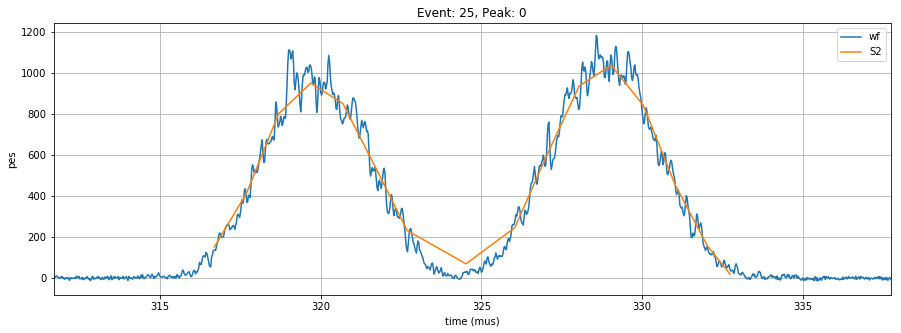

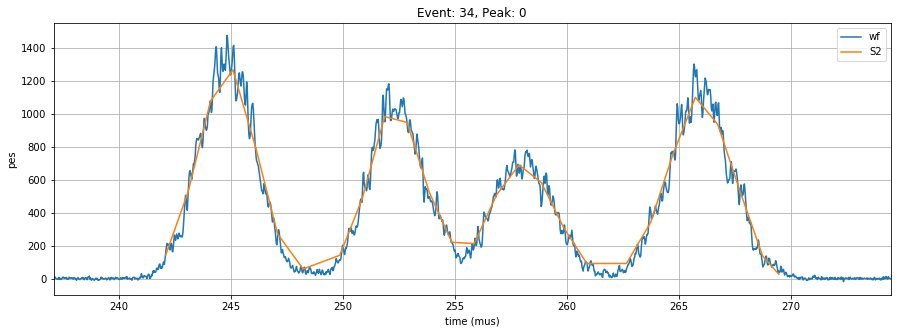

In [7]:
print('**Note I have multiplied the csum values by 40 pes to account for the rebinning.')
def plot_wvfm_vs_S2(irene, f_rwf, events, S2s):
    with tb.open_file(infile, 'r+') as f:
        CSUMs = {}
        for ev in events:
            CSUMs[ev] = irene.calibrated_pmt_sum(irene.deconv_pmt(f.root.RD.pmtrwf[ev]))[0]
            for p in S2s[ev]:
                plt.figure(figsize=(15,5))
                plt.plot(np.arange(48000) * 25 / 1000, CSUMs[ev] * 40* units.pes, label='wf')
                plt.plot(S2s[ev][0][0] / units.mus, S2s[ev][0][1], label='S2')
                plt.title('Event: '+ str(ev) + ', Peak: ' + str(p))
                plt.xlim(S2s[ev][p][0][0] / units.mus - 5, S2s[ev][p][0][-1] / units.mus + 5)
                plt.legend()
                plt.grid(True)
                plt.ylabel('pes')
                plt.xlabel('time (mus)')
                plt.show()          
plot_wvfm_vs_S2(irene, infile, events_with_large_S2_timebins, S2s)

Notice that the troughs are cut in the S2 separate a bit from the waveform.. That is because there is missing (threshold-suppresed) data in this region.

## Solution
#### QUICK FIX: modify the rebin waveform function
I've commented out then lines of code that I have changed, and changed them just below.

In [8]:
def rebin_waveform_debugged(t, e, stride=40):
    """
    Rebin a waveform according to stride
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns the rebinned T and E vectors
    NB: This function is used mainly for testing purposed. It is
     programmed "c-style", which is not necesarily optimal
    in python, but follows the same logic that the corresponding cython
    function (in peak_functions_c), which runs faster and should be used
    instead of this one for normal calculations.
    """

    assert len(t) == len(e)
    assert (units.mus / units.ns) % stride == 0

    #n = len(t) // stride
    #r = len(t) %  stride
    t_start  = int((t[ 0] //   units.mus) * units.mus)
    t_finish = int( t[-1] + 25*units.ns )
    t_total  = (t_finish - t_start)
    n = int(t_total // units.mus)
    r = int(t_total  % units.mus)

    lenb = n
    if r > 0:
        lenb = n+1

    T = np.zeros(lenb, dtype=np.double)
    E = np.zeros(lenb, dtype=np.double)

    j = 0
    for i in range(n):
        esum  = 0
        tmean = 0
        #for k in range(j, j + stride):
        #    esum  += e[k]
        #    tmean += t[k]
        for tb in range(int(t_start + i*units.mus), int(t_start + (i+1)*units.mus), int(25*units.ns)):
            if t[j] == tb: 
                esum += e[j]
                j    += 1
            elif t[j]  > tb: 
                esum += 0 # or the threshold? (if 0 can delete)
            else:
                print(tb,t[j])
                raise ValueError    
            #tmean += tb

        #tmean /= stride
        #j     += stride
        #T[i]  += tmean
        E[i] = esum
        if i == 0: T[i] = (t[0] + t_start + units.mus) / 2.
        else     : T[i] = (t_start + i*units.mus + 500*units.ns)

    if r > 0:
        esum  = 0
        tmean = 0
        #for k in range(j, len(t)):
        #    esum  += e[k]
        #    tmean += t[k]
        for tb in range(int(t_start + n*units.mus), t_finish, int(25*units.ns)):
            if t[j] == tb: 
                esum += e[j]
                j    += 1
            elif t[j]  > tb: 
                esum += 0 # or the threshold? (if 0 can delete)
            else: 
                raise ValueError  
                
        #tmean /= (len(t) - j)
        #T[n]   = tmean
        E[n] = esum
        T[n] = (t_start + n*units.mus + t_finish) / 2

    return T, E

Now we need to run irene by hand with this `rebin_waveform` function to see if BUG1 has been remedied. Let's look specifically at event 34, peak 0.

In [9]:
# python version of find_S12 taken from peak_functions modified to call 
# rebin_waveform_debugged()
def find_S12_py(wfzs, index,
             time   = minmax(0, 1e+6),
             length = minmax(8, 1000000),
             stride=4, rebin=False, rebin_stride=40, debugged=False):
    """
    Find S1/S2 peaks.
    input:
    wfzs:   a vector containining the zero supressed wf
    indx:   a vector of indexes
    returns a dictionary
    do not interrupt the peak if next sample comes within stride
    accept the peak only if within [lmin, lmax)
    accept the peak only if within [tmin, tmax)
    returns a dictionary of S12
    NB: This function is used mainly for testing purposed. It is programmed
     "c-style", which is not necesarily optimal
    in python, but follows the same logic that the corresponding cython
    function (in peak_functions_c), which runs faster and should be used
    instead of this one for nornal calculations.
    """

    P = wfzs
    T = pf.time_from_index(index)

    assert len(wfzs) == len(index)

    S12  = {}
    S12L = {}
    s12  = []

    S12[0] = s12
    S12[0].append([T[0], P[0]])

    j = 0
    for i in range(1, len(wfzs)) :

        if T[i] > time.max:
            break

        if T[i] < time.min:
            continue

        if index[i] - stride > index[i-1]:  #new s12
            j += 1
            s12 = []
            S12[j] = s12
        S12[j].append([T[i], P[i]])
        
    S12
    # re-arrange and rebin
    j = 0
    for i in S12:
        ls = len(S12[i])

        if not (length.min <= ls < length.max):
            continue

        t = np.zeros(ls, dtype=np.double)
        e = np.zeros(ls, dtype=np.double)

        for k in range(ls):
            t[k] = S12[i][k][0]
            e[k] = S12[i][k][1]

        if rebin == True:
            if debugged:
                TR, ER = rebin_waveform_debugged(t, e, stride = rebin_stride)
            else:
                TR, ER = rebin_waveform         (t, e, stride = rebin_stride)
            S12L[j] = [TR, ER]
        else:
            S12L[j] = [t, e]
        j += 1
    return S12L

In [10]:
S2sc = {}
S2sb = {}
Sisc = {}
Sisb = {}

with tb.open_file(infile, 'r') as f: 
    for ev in events_with_large_S2_timebins:
        s1_ene, s1_indx, s2_ene, s2_indx, csum = irene.pmt_transformation(f.root.RD.pmtrwf[ev])
        sipmzs = irene.calibrated_signal_sipm(f.root.RD.sipmrwf[ev])
            
        S2sc[ev] = find_S12_py(s2_ene,s2_indx,
                    **irene.s2_params._asdict(), debugged=True)
        
        S2sb[ev] = find_S12_py(s2_ene,s2_indx,
                    **irene.s2_params._asdict(), debugged=False)
        
        Sisc[ev] = irene.find_S2Si(S2sc[ev], sipmzs)
        Sisb[ev] = irene.find_S2Si(S2sb[ev], sipmzs)

#### BUG 1 (nearly) fixed.

In [11]:
still_large_timebins = []

for ev in S2sc: 
    for p in S2sc[ev]:
        if p in Sisc[ev]:
            if (S2sc[ev][p][0][-1] - S2sc[ev][p][0][0]) / units.mus > len(Sisc[ev][p][next(iter(Sisc[ev][p]))]):
                still_large_timebins.append(ev)
                         
if len(still_large_timebins) > 0:
    print('The time spanned in S2 is greater than the time spanned in Si in these events:')
    print(still_large_timebins)
else: print('No obviously mismatched S2s and S2Sis in time')
print('')
    
for ev in events_with_large_S2_timebins:
    print('Event: ', ev)
    print('Differences between the times saved in S2')
    print([S2sc[ev][0][0][i] - S2sc[ev][0][0][i-1] for i in range(1, len(S2sc[ev][0][0]))])
    print('=======')
print('')

No obviously mismatched S2s and S2Sis in time

Event:  25
Differences between the times saved in S2
[900.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Event:  34
Differences between the times saved in S2
[737.5, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 850.0]



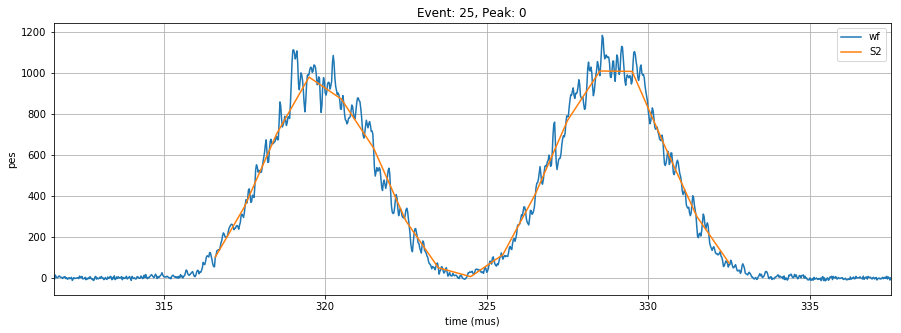

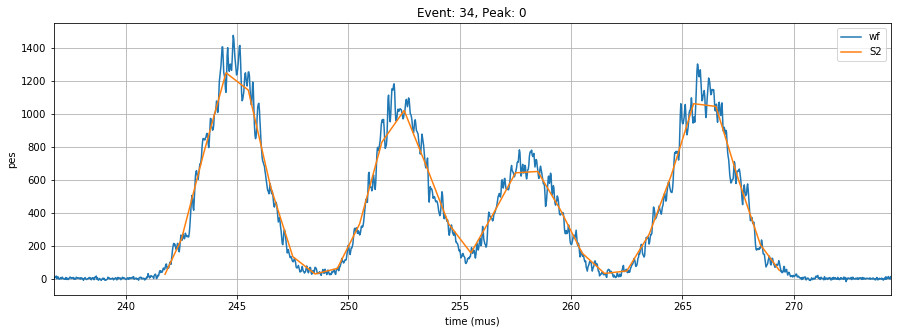

In [12]:
plot_wvfm_vs_S2(irene, infile, events_with_large_S2_timebins, S2sc)

So the quick fix prevents us from accidentally creating timebins larger than 1 microsecond! It also improves the S2's ability to follow the troughs of double (or quadruple) peaked S2s! ~See improvement over plot shown above~

It turns out completely eradicating this bug is requires changing more than just this one function. `rebin_waveform` should sent be a chunk of waveform corresponding to the S2, and not a threshold suppressed waveform... This is because we are suppressing some energy in the troughs of these (albeit strange) S2s which could hurt our energy resolution a tiny, tiny bit. (Everytime the if statements on lines 43 and 67 are evaluated as true, we throw away a maximum of `irene.thr_csum_s2` pes, because we do not have access to these energy values because they were discarded in the threshold suppression).

Really the fix shouldn't be complicated and should actually simplify the code. 

### ONE LAST THING: 
more important than all the rest. We during this debugging, another problem was identified with `rebin_waveform`:

![alt text](bug2.png "Title")
## Our quick fix presented in `rebin_waveform_debugged` also fixes this problem!


## TESTS
#### Bug 1

In [13]:
# THESE SHOULD COVER BUG 1
def test_max_S2_timebin_size(S2s, max_timebin_size=units.mus):
    for S2s_ev in S2s.values(): # event loop
        for S2_p in S2s_ev.values(): # peak loop 
            assert (np.array([S2_p[0][i] - S2_p[0][i-1] \
                     for i in range(1, len(S2_p[0]))])  \
                     <= max_timebin_size).all()

def test_all_middle_timebins_of_same_size(S2s, timebin_size=units.mus):
    """
    All the S2 timebins except the first and last should have the same
    size. Normally 1 microsecond.
    """
    for S2s_ev in S2s.values(): # event loop
        for S2_p in S2s_ev.values(): # peak loop 
            assert (np.array([S2_p[0][i] - S2_p[0][i-1]  \
                     for i in range(2, len(S2_p[0]) -1)])\
                     == timebin_size).all()

#### Before:

In [14]:
test_max_S2_timebin_size(S2s)

AssertionError: 

In [15]:
test_all_middle_timebins_of_same_size(S2s)

AssertionError: 

#### After:

In [16]:
test_max_S2_timebin_size(S2sc)
test_all_middle_timebins_of_same_size(S2sc)
# No news is good news

#### This should not fail because it was not actually broken, however it is a good test to maintain!

In [17]:
def test_equal_number_of_timebins_in_S2s_and_S2Sis(S2s, S2Sis):  
    for S2, Si in zip(S2s.values(), S2Sis.values()):
        for p in S2:
            if p in Si:
                assert len(Si[p][next(iter(Si[p]))]) == len(S2[p][0])
test_equal_number_of_timebins_in_S2s_and_S2Sis(S2s, S2Sis)

#### Bug 2

In [18]:
def test_aligned_S2_and_SiS2_timebins(S2s):
    # TEST ONLY WORKS IN THIS CASE:
    timebin_size = units.mus 
    for S2 in S2s.values():
            for S2_p in S2.values():
                for tb in range(1, len(S2_p[0]) - 1):
                    assert S2_p[0][tb] % timebin_size == 500

#### Before

In [19]:
test_aligned_S2_and_SiS2_timebins(S2s)

AssertionError: 

#### After

In [20]:
test_aligned_S2_and_SiS2_timebins(S2sc)